# Análise dos resultados (V2)

## Configurando o Ambiente
---

### Importação de Módulos

In [1]:
!pip install -q scikit_posthocs

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as w
import colorcet as cc
import seaborn as sns
from scipy import stats
import scikit_posthocs as sp

In [34]:
plt.rcParams['figure.dpi'] = 100

O módulo `utils.py` contém definições a respeito das configurações dos experimentos:

In [4]:
%load_ext autoreload
%autoreload 2
import utils

### Definição de Funções

In [5]:
def apply_friedman_tests(observations :pd.DataFrame, alpha=.05) -> pd.DataFrame:
    
    N, M = observations.shape

    observation_list = [observation for _, observation in observations.items()]
    chisquare_result = stats.friedmanchisquare(*observation_list)
    chi_stat = chisquare_result.statistic
    chi_pvalue = chisquare_result.pvalue

    # Utiliza o chi quadrado do friedman para derivar a estatísica menos conservadora de Iman e Davenport (1980)
    F_stat = ((N-1)*chi_stat)/(N*(M-1) - chi_stat)

    ## Graus de liberdade da distribuição F que distribui a F_stat no teste acima
    dfn = M - 1
    dfd = (M-1)*(N-1)
    F_pvalue = stats.f.sf(F_stat, dfn, dfd)

    index = ["$\chi^2_F$", "$F_F$"]

    df =  pd.DataFrame({"Static Value": [chi_stat, F_stat], "$p$ value": [chi_pvalue, F_pvalue]}, index=index)
    
    color_function = lambda x: f'background-color: {"red" if x >= alpha else "green"}'
    
    return df.style.applymap(color_function, subset=["$p$ value"]).set_caption(fr"Friedman Test ($\alpha={alpha}$)")

### Importação de Resultados

In [6]:
def get_results_info(file_list: list) -> pd.DataFrame:
    
    results_info = pd.DataFrame(file_list, columns=["file"])
    results_info[["dataset", "split", "learner", "method"]] = results_info.file.str.split("_", n=3, expand=True)
    results_info['file'] = results_info.file.map(lambda x: os.path.join(utils.RESULTS_V2_PATH, x))
    results_info['method'] = results_info.method.apply(lambda x: x.split('.')[0])
    
    return results_info

def get_results_df(results_info) -> pd.DataFrame:
    df = pd.concat(pd.read_csv(f) for f in  results_info.file)

    df['time'] = pd.to_datetime(df.time)
    
    return df
    

In [7]:
%%time
csv_files = !ls  $utils.RESULTS_V2_PATH
results_info = get_results_info(csv_files)
results_df = get_results_df(results_info)

CPU times: user 20.8 s, sys: 2.03 s, total: 22.8 s
Wall time: 35.5 s


## Análise de Ranks
----

Dado um método de AL $q \in \mathcal{Q}$, um aprendiz $a \in \mathcal{A}$ e um conjunto de dados $D \in \mathcal{S}$, temos que o desempenho do par $(q, a)$ em dataset $D$ (*Active Learning Performance*) é dado por:

$$
\text{ALP}_D(q, a)  = \text{rank}(\frac{1}{5}\sum_{i=1}^{5}{AULC(q, a, D^i_{train}, D^i_{test})})
$$

onde $AULC$ corresponde à _area under the learning curve_ e $D^i_{train}, D^i_{test}$ aos conjuntos de treino e teste para uma validação cruzada de 5 folds, e $rank$ ao rank obtido em comparação com os outros metodos e algoritmos aplicados em $D$

### Análise Geral

Com base nessa defição, podemos utilizar o desempenho de um par em diferentes datasets, para estimar seu desempenho geral:

$$
ALP(q, a) = \frac{1}{|\mathcal{S}|}\sum_{D \in \mathcal{S}} ALP_D(q,a)
$$


Calculando os valores de $ALP_D$:

In [8]:
alp_D_df = (results_df.groupby(["classifier", "dataset", "method", "fold"])["kappa"]
                    .apply(np.trapz)
                    .groupby(["classifier", "method", "dataset"])
                    .mean()
                    .rename("ALP")
                    .reset_index())

alp_D_df['rank'] =  alp_D_df.groupby("dataset").ALP.rank(ascending=False)

Verificando se existe alguma diferença estatísitca por meio do teste de Friedman:

In [9]:
observations_df = alp_D_df.pivot(index="dataset", columns=["classifier", "method"], values="ALP")
apply_friedman_tests(observations_df)

,Static Value,$p$ value
$\chi^2_F$,1213.960168,0.000000
$F_F$,15.290383,0.000000


Aplicando o teste de Nemenyi para calcular a _critical distance_ ($CD$):

In [10]:
from autorank import autorank
from IPython.display import Math
autorank_result = autorank(observations_df, alpha=0.05)
Math(f"CD \\approx {autorank_result.cd:.2f} \\, (\\alpha = {autorank_result.alpha})")

<IPython.core.display.Math object>

Com base nisso podemos comparar os ranks médios:

In [11]:
alp_df = alp_D_df.groupby(["method","classifier"])["rank"].mean().sort_values().reset_index()
alp_df["interval"] = alp_df['rank'].map(lambda x: f'({x-autorank_result.cd:.2f}, {x + autorank_result.cd:.2f})')
max_idx = alp_df.groupby("classifier")["rank"].idxmax()
min_idx = alp_df.groupby("classifier")["rank"].idxmin()
rnd_idx = alp_df[alp_df.method == 'random_sampling'].index
classic_idx =  alp_df[alp_df.method.map(utils.get_hm_type) == 'Classic'].index

def pretty_rank_table(styler):

    colnames = lambda x: str.capitalize(x.split('_')[0])
    
    styler.set_caption("Avg. Ranks Table")
    styler.format(precision=2)
    styler.format(utils.ABREV_MODEL.get, subset=[f'classifier_{i}' for i in range(4)])
    styler.format(utils.ABREV_DICT.get, subset=[f'method_{i}' for i in range(4)])
    styler.format_index(colnames, axis=1)
    styler.hide(axis="index")
    styler.applymap(lambda x: 'background-color: gray' if x in classic_idx.to_list() else '')
    styler.applymap(lambda x: 'background-color: orange' if x in rnd_idx.to_list() else '')
    styler.applymap(lambda x: 'background-color: green' if x in min_idx.to_list() else '')
    styler.applymap(lambda x: 'background-color: red' if x in max_idx.to_list() else '')

    return styler

n = 4
slice_len = len(alp_df)//n
slices = [alp_df.iloc[i*slice_len : (i+1)*slice_len].reset_index().rename(columns=lambda x: f'{x}_{i}') for i in range(n)]
square = pd.concat(slices, axis=1)
square.style.pipe(pretty_rank_table)

Index,Method,Classifier,Rank,Interval,Index,Method,Classifier,Rank,Interval,Index,Method,Classifier,Rank,Interval,Index,Method,Classifier,Rank,Interval
0,$TU$,$CART$,21.62,"(4.44, 38.81)",23,$F4I$,$CART$,37.92,"(20.74, 55.11)",46,$N1I$,$NB$,47.77,"(30.59, 64.96)",69,$EER_{ent}$,$CART$,53.21,"(36.03, 70.40)"
1,$Rnd$,$CART$,26.16,"(8.97, 43.34)",24,$DS$,$SVM$,38.34,"(21.16, 55.53)",47,$F1I$,$CART$,48.33,"(31.15, 65.52)",70,$F2I$,$SVM$,53.54,"(36.36, 70.73)"
2,$kDN$,$SVM$,28.04,"(10.86, 45.23)",25,$H$,$SVM$,38.98,"(21.79, 56.16)",48,$MV$,$CART$,48.81,"(31.63, 66.00)",71,$MS$,$CART$,53.56,"(36.37, 70.74)"
3,$TU$,$NB$,29.29,"(12.10, 46.47)",26,$N1I$,$CART$,39.38,"(22.19, 56.56)",49,$DCP$,$CART$,49.02,"(31.84, 66.21)",72,$F4I$,$NB$,53.86,"(36.67, 71.04)"
4,$LSR$,$CART$,31.46,"(14.27, 48.64)",27,$TD_U$,$5NN$,40.12,"(22.94, 57.31)",50,$H$,$NB$,49.10,"(31.91, 66.29)",73,$EER_{ent}$,$NB$,54.62,"(37.43, 71.80)"
5,$LSR$,$SVM$,31.50,"(14.31, 48.69)",28,$MS$,$5NN$,40.96,"(23.77, 58.14)",51,$TD_P$,$5NN$,49.13,"(31.95, 66.32)",74,$N2I$,$SVM$,55.36,"(38.17, 72.54)"
6,$Rnd$,$NB$,32.04,"(14.86, 49.23)",29,$TD_P$,$SVM$,41.63,"(24.45, 58.82)",52,$EER_{ent}$,$SVM$,49.22,"(32.04, 66.41)",75,$TU$,$SVM$,55.74,"(38.56, 72.93)"
7,$TD_U$,$SVM$,32.30,"(15.11, 49.49)",30,$F3I$,$CART$,42.63,"(25.45, 59.82)",53,$CB$,$CART$,50.03,"(32.85, 67.22)",76,$CB$,$5NN$,55.78,"(38.59, 72.96)"
8,$CLD$,$SVM$,32.62,"(15.44, 49.81)",31,$CLD$,$5NN$,42.83,"(25.65, 60.02)",54,$DS$,$NB$,50.05,"(32.86, 67.24)",77,$MV$,$5NN$,55.78,"(38.59, 72.96)"
9,$Rnd$,$SVM$,33.99,"(16.80, 51.17)",32,$TD_U$,$NB$,43.43,"(26.25, 60.62)",55,$TD_P$,$NB$,50.10,"(32.91, 67.29)",78,$F4I$,$5NN$,56.60,"(39.41, 73.79)"


Com base nessa tabela, podemos derivar as seguintes conclusões:

1. Com 95% de confiança não há diferença estatística entre os 24 primeiros colocados ($0 \leq index \leq 23$)
2. $Rnd$ foi a  **única** estratégia ocupando esse grupo para todos os algoritmos de aprendizado utilizados
3. $Rnd$ foi a **única** estratégia capaz de fazer $5NN$ ocupar esse grupo.
4. Apesar da boa colocação de $TU$ para $CART$ e $NB$, ele obteve obteve colocações efetivamente piores para $5NN$ e $SVM$
5. $MS$ foi melhor que $TU$ para $SVM$ e, com uma confiança um pouco menor, para $5NN$
6. Mais da metade dos pares que se utilizavam de métodos clássicos (9/16) ficaram efetivamente abaixo de $(Rnd,5NN)$
7. Mesmo separando os métodos que não podem ser tidos como piores que o primeiro colocado, apenas TU e TDu apresentaram um desempenho estatisticamente diferente para outros algoritmos
8. Overlap muito grande para a maioria das regiões

Agrupando métodos que não possuem diferençca estatística com o primeiro colocado:

In [12]:
first_group = alp_df[alp_df["rank"] < alp_df.iloc[0]['rank']+ autorank_result.cd].copy()
first_group.style.format(precision=2).format(utils.ABREV_MODEL.get, subset="classifier").format(utils.ABREV_DICT.get, subset="method").background_gradient(gmap=pd.Categorical(first_group.classifier).codes)

,method,classifier,rank,interval
0,$TU$,$CART$,21.62,"(4.44, 38.81)"
1,$Rnd$,$CART$,26.16,"(8.97, 43.34)"
2,$kDN$,$SVM$,28.04,"(10.86, 45.23)"
3,$TU$,$NB$,29.29,"(12.10, 46.47)"
4,$LSR$,$CART$,31.46,"(14.27, 48.64)"
5,$LSR$,$SVM$,31.50,"(14.31, 48.69)"
6,$Rnd$,$NB$,32.04,"(14.86, 49.23)"
7,$TD_U$,$SVM$,32.30,"(15.11, 49.49)"
8,$CLD$,$SVM$,32.62,"(15.44, 49.81)"
9,$Rnd$,$SVM$,33.99,"(16.80, 51.17)"


Verificando a frequencia de cada algoritmo nesse grupo:

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

method_count = first_group.groupby("classifier").method.unique()
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(method_count)
pd.DataFrame(labels, columns=map(utils.ABREV_DICT.get, mlb.classes_), index=method_count.index).style.background_gradient(vmin=0, vmax=1 )

,$N1I$,$CL$,$CLD$,$DCP$,$DS$,$F4I$,$H$,$kDN$,$LSCI$,$LSR$,$MS$,$Rnd$,$TU$,$TD_U$,$U$
classifier,,,,,,,,,,,,,,,
5NN,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
DecisionTree,0,1,1,0,0,1,1,1,1,1,0,1,1,0,0
GaussianNB,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0
SVC,1,1,1,1,1,0,0,1,1,1,1,1,0,1,1


1. $TU$ é o único clássico a aparecer nessa região
1. $Rnd$ é o único que aprece em todos os casos (foi capaz de igualar o desempenho médio dos algoritmos?)
1. $NB$ só aparece para $TU, Rnd$ e $LSR$
1. $LSR$ está presentes para $CART, NB$ e $SVM$
1. $CL, CLD, kDN, LSCI$ estão presentes para $CART$ e $SVM$

Entretnato, nessa região, apenas pares contendo $TU$ e $TD_u$ apresentaram diferença estatísica entre os algoritmos de aprendizado

In [14]:
(alp_df.groupby("method")["rank"].apply(np.ptp)
 .sort_values(ascending=False)
 .to_frame("interval_size").T
 .style.format_index(utils.ABREV_DICT.get, axis=1)
 .applymap(lambda x: 'color: red' if x < autorank_result.cd else 'color: green' ))

method,$TU$,$ID$,$MV$,$CB$,$F4I$,$F3I$,$TD_U$,$F1I$,$MS$,$kDN$,$H$,$F2I$,$CL$,$LSCI$,$LSR$,$N1I$,$DS$,$DCP$,$CLD$,$N2I$,$EER_{ent}$,$TD_P$,$Rnd$,$U$
interval_size,36.088889,24.733333,18.905556,18.905556,18.677778,18.511111,18.244444,17.355556,17.077778,16.522222,16.477778,16.194444,15.438889,15.244444,14.577778,14.533333,13.233333,12.333333,12.050000,11.188889,10.811111,9.500000,9.266667,0.000000


1. No caso de $TU$, isso se deve a seu desempenho com $SVM$ e $5NN$
2. No caso de $ID$, $CART$(61) foi melhor que $5NN$(91)
3. No caso de $MV$, $SVM$ (42) foi melhor que $NB$ (90)
3. No caso de $CB$, $SVM$ (41) foi melhor que $NB$ (89)
3. No caso de $F4I$, $CART$ (22) foi melhor que $5NN$ (77)
3. No caso de $F3I$, $CART$ (29) foi melhor que $NB$(82) e $5NN$(83)
5. No caso de $TD_U$, $SVM$ (7) foi melhor que $CART$ (58)
3. No caso de $F1I$, $CART$ (46) foi melhor que $NB$(87)


Apesar das suspeitas que medidas tree-based são melhores para classificadores não baseados em arvore, só consigo dizer que TDu foi melhor que CART para SVM

### Análise por Algoritmo
-----

In [15]:
def get_observations(alp_D_df, clf_name):
    return alp_D_df[alp_D_df.classifier == clf_name].pivot(index="dataset", columns="method", values="ALP")

In [16]:
observations = {clf: get_observations(alp_D_df, clf) for clf in alp_D_df.classifier.unique()}


#### Teste de Friedman

Verificando se existe diferença entre os métodos para um único classificador:

In [17]:
def show_fried(clf):
    return apply_friedman_tests(observations[clf])
    
w.interact(show_fried, clf=w.ToggleButtons(options=observations.keys(), description="Algoritmo"))

interactive(children=(ToggleButtons(description='Algoritmo', options=('5NN', 'DecisionTree', 'GaussianNB', 'SV…

<function __main__.show_fried(clf)>


#### Teste de Nemenyi

In [18]:
def apply_nemenyi(observations):
    df = sp.posthoc_nemenyi_friedman(observations)
    
    sorted_index= observations.rank(axis=1, ascending=False).mean().sort_values().reset_index().method.values

    df = df.loc[sorted_index, sorted_index]
    
    linhas, colunas = np.tril_indices_from(df, k=-1)

    df.values[linhas, colunas] = 1
    
    return df.style.pipe(show_nemenyi_table).set_caption(f"One versus one")


def show_nemenyi_table(styler, expand=False):
    def format_names(x):
        res = x.split('-')
        method = res[0]
        classifier = res[1] if len(res) > 1 else ''

        final = f'{utils.ABREV_DICT[method].strip()}'
        
        if classifier:
            final+=f'+{utils.ABREV_MODEL[classifier]}'
            
        return final

    def color_index(s):
        return ["background-color: darkblue" if utils.get_hm_type(x.split('-')[0]) != 'Classic' else "" for x in s] 
    
    def color_cells(s):
        return ['color: green' if x <=0.01 
                else 'color: lightgreen' if x <= 0.05
                else 'color: orange' if x <= .1
                else 'color: red' if x>=1
                else ''
                for x in s]
        
    def format_significance(val):
        if val < 0.01:
            return '*'
        elif val < 0.05:
            return '+'
        elif val <0.1:
            return '.'
        else:
            return ''
            

    styler.apply_index(color_index, axis=0)
    styler.apply_index(color_index, axis=1)
    styler.format_index(format_names, axis=0)
    styler.format_index(format_names, axis=1)
    if expand:
        styler.apply(color_cells, axis=1)
    else:
        styler.format(format_significance)
    styler.set_properties(**{'text-align': 'center'})


    return styler
    
    

Marcadores se significância:
- `*` ($\alpha = 0.01$);
-  `+` ($\alpha = 0.05$);
- `.` ($\alpha = 0.1$)

In [19]:
def show_nemenyi(clf):
    return apply_nemenyi(observations.get(clf))
w.interact(show_nemenyi, clf=w.ToggleButtons(options=observations.keys()))    

interactive(children=(ToggleButtons(description='clf', options=('5NN', 'DecisionTree', 'GaussianNB', 'SVC'), v…

<function __main__.show_nemenyi(clf)>

Uma análise geral dos testes sugere que, para $p < 0.1$:
1. Nenhum método se provou melhor que $Rnd$ 
1. Nenhum método se provou melhor que todos os clássicos.
4. Independente do algoritmo, nenhum método foi capaz de superar todos as clássicos
2. Para todos os algortimos, apenas $Rnd$ e $LSR$ foram capazes de superar 3 clássicos
2. Para todos os algortimos, um dos métodos clássicos foi capaz de superar os 3 clássicos restantes (_melhor clássico_).
3. O melhor clássico vairou entre $TU$ (CART e NB) e $MS$ (SVM e 5NN)
4. Desconsiderando CART, $LSR$ foi o único método que não foi superado pelo topline para os 3 algoritmos

##### 5NN

- Não foi pior que o topline/baseline: 
    - Clássicos: $MS$
    - HardS: $TD_U, kDN, LSR, CLD, DCP, TD_P, LSCI, DS$
- Superou restante dos classicos:
    - Baseline: $Rnd$
    - Clássicos: $MS$
    - HardS: $TD_U, kDN, LSR, CLD$


##### CART

- Não foi pior que o topline ($TU$):
    - Baseline: $Rnd$
- Não foi pior que o baseline:
    - Clássicos:$TU$
    - HardS: $LSR, LSCI, kDN$
- Superou restante dos clássicos:
    - Clássicos:$TU$
    - Baseline: $Rnd$
    - HardS: $LSR, LSCI, kDN, H, CL, F4I, CLD, N1I$

##### Naive Bayes

- Não foi pior que o topline ($TU$):
    - Baseline: $Rnd$
    - HardS: $LSR$
- Não foi piuor que o baseline ($Rnd$):
    - Classicos: $TU$
    - HardS: $LSR, TD_u,kDN, LSCI$
- Venceu restante clássicos:
    - Classico: $TU$
    - Baseline: $Rnd$
    - HardS: $LSR$

##### SVM

- Não foi pior que o topline ($kDN$):
    - Basline: $Rnd$
    - Classicos: $MS$
    - HardS: $LSR, CLD, TD_U, LSCI, DCP, DS, N1I, CL$
- Não foi pior que o baseline:
    - Classicos: $MS$
    - HardS: $LSR, CLD, TD_U, LSCI, DCP, DS, N1I, CL, H, TD_p$
- Venceu restate clássicos:
    - Classicos: $MS$
    - Basline: $Rnd$
    - HardS: $kDN, LSR, CLD, TD_U, LSCI, DCP, DS, N1I, CL$



### Considerações

Sobre os métodos clássicos:
1. Enquanto $EER$ e $ID$ métodos clássicos foram constantemente superados, $TU$ e $MS$ bons desempenhos, sugerem uma dependencia maior no algoritmo

Como nenhum dos métodos foi capaz de superar o baseline, nos resta recomendar métodos que não foram comprovados inferiores aos métodos *basline/topline*
- $LSR$ parece uma boa recomendação geral, visto que foi o único método a não ser superado pelo topline ou pelo $Rnd$ em nenhum dos casos (considerando $p < 0.05$)
- $LSCI$ e $kDN$ também parecem boas recomendações, visto que não foram tidos como inferiores ao $Rnd$ em nenhum dos casos
- Se desconsiderarmos $CART$ (classificador baseado em árvore), $TD_U$ parece uma boa alternativa
- Sobre grupos:
    - Neighborhood-based pareceram ser melhores, mas algumas foram superadas constantemente ($N2I$, $N1I$, $H$)
    - Medidas Likelihood-based parecem promissoras, mas menos robustas que as melhores Neighborhood-based
    - Medidas Tree-based além de TD_u não parecem tão promissoras
    - No geral, métodos Feature-based e Class-Balance não parecem boas alternativas, visto que foram constantemente superados pelo $Rnd$

## Análise de Curvas 
---

### Curvas de Aprendizado
---


In [35]:
# Definindo as cores para os plots:
n_methods = results_info.method.nunique()
color_list = sns.color_palette(cc.glasbey_dark ,n_colors=n_methods)
COLOR_DICT = dict(zip(results_info.method.unique().tolist(), color_list))
COLOR_DICT["random_sampling"] = "firebrick"

In [21]:
def plot_learning_curve(dataset, learner):

    plt.close()
    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_ylim(-1,1)
    ax.set_title(f"Average learning curves for AL methods")
    
    
    result_files = results_info[(results_info.learner == learner) & (results_info.dataset == dataset)].file.tolist()

    results_df = pd.concat(pd.read_csv(f) for f in result_files)

    auc_dict = {}
    for method, data in results_df.groupby("method"):
        avg_scores =  data.groupby("query").kappa.mean()
        auc = (np.trapz(avg_scores, avg_scores.index))
        auc_dict[method] = auc

    ranked_method_list = sorted(auc_dict.items(), key=lambda x: x[1],reverse=True)

    i=0
    for method, _ in ranked_method_list:
        avg_curve = results_df[results_df.method == method].groupby("query").kappa.mean()
        ax.plot(avg_curve.rolling(window=5, min_periods=1).mean(),
                utils.get_style(method), 
                linewidth=0.5 if utils.get_hm_type(method) != 'Classic' else 1.5,
                color=COLOR_DICT[method],
                label=utils.ABREV_DICT[method],
                markevery=(0.3, 0.2))
        i+=1
        
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.02), ncols=1, prop={'size':8}, framealpha=1)

In [36]:
w.interact(plot_learning_curve,
          dataset=w.SelectionSlider(options=utils.DATASET_LIST),
          learner=w.ToggleButtons(options=sorted(utils.ABREV_MODEL.keys()), value="SVC"))

interactive(children=(SelectionSlider(description='dataset', options=('abalone-3class', 'artificial-characters…

<function __main__.plot_learning_curve(dataset, learner)>

### Curvas de Ranking com Bandas
---

In [23]:
def get_avg_ranks(results_df) -> pd.DataFrame:
    # Afere o kappa médio para cada query registrada
    avg_kappa = results_df.groupby(["classifier","method", "query", "dataset"]).kappa.mean()

    # Afere o rank de cada método para cada dataset
    ranks_df = avg_kappa.to_frame(name="kappa")
    ranks_df['rank'] = ranks_df.groupby(["query", "dataset"]).kappa.rank(ascending=False)

    # Calcula rank médio por query para cada 
    avg_ranks = ranks_df.groupby(["classifier", "method", "query"])["rank"].mean()
    return avg_ranks


In [24]:
avg_ranks_df = get_avg_ranks(results_df)

In [25]:
def plot_ranking_curves_with_bands(avg_ranks):

    fig, ax = plt.subplots()
    ax.set_title("Ranking Curves with Bands")
    ax.set_ylabel("Avg. Rank")
    ax.set_xlabel("Queries")
    ax.invert_yaxis()
    ax.grid(True)
    
    smoothed_ranks =  avg_ranks.groupby(["classifier","method"]).transform( lambda x: x.rolling(window=5, min_periods=1).mean())

    auc_data = smoothed_ranks.groupby(["classifier", "method"]).apply(np.trapz)

    for clf, data in smoothed_ranks.groupby("classifier"):
        worst = auc_data[clf].idxmax()
        best  = auc_data[clf].idxmin()
        
        upper_limmit = smoothed_ranks[clf].groupby("query").max()
        lower_limmit = smoothed_ranks[clf].groupby("query").min()

        
        
        p = ax.plot(smoothed_ranks[clf, best], utils.get_style(best),
                    label=(utils.ABREV_MODEL[clf], utils.ABREV_DICT[best]),
                    linewidth=0.5,
                    markevery=(0.3,0.2))
        color = p[0].get_color()
        
        ax.plot(smoothed_ranks[clf, worst], utils.get_style(worst),
                label=(utils.ABREV_MODEL[clf], utils.ABREV_DICT[worst]), color=color,
                linewidth=0.5,
                markevery=(0.3,0.2))
        
        ax.fill_between(np.arange(101), upper_limmit, lower_limmit, color=color, alpha=0.3)

    ax.legend(loc="upper right",bbox_to_anchor=(1.23,.70),ncol=1, prop={'size': 8}, framealpha=1)

    return 

### Curvas de Ranking por Algoritmo

In [53]:
def plot_learning_curves(avg_ranks_df, classifier):

    fig, ax = plt.subplots(figsize=(6,5))
    ax.grid(True)
    ax.invert_yaxis()
    # ax.set_title(classifier)
    ax.set_xlabel("Queries")
    ax.set_ylabel("Avg. Ranks")
    

    # Calcula rank médio por query para cada 
    clf_ranks = avg_ranks_df.loc[classifier]
    auc_scores = {}
    for method, data in clf_ranks.groupby("method", sort=False):

        # aplica média móvel nos dados:
        smoothed_data = data.rolling(window=5, min_periods=1).mean()

        auc_scores[utils.ABREV_DICT[method]] = np.trapz(smoothed_data)
        
        ax.plot(smoothed_data.values, utils.get_style(method),
                label=utils.ABREV_DICT.get(method), color=COLOR_DICT[method], markevery=(0.3, 0.2),
                linewidth=(0.5 if utils.get_hm_type(method) != 'Classic' else 1.5) )
        
    handles, labels = plt.gca().get_legend_handles_labels()
    label_to_handle = {l: h for l, h in zip(labels, handles)}

    sorted_labels = sorted(auc_scores, key=auc_scores.get)
    plt.legend([label_to_handle[label] for label in sorted_labels],
               sorted_labels,
               loc='upper right', bbox_to_anchor=(1.2, 1.02), ncols=1, prop={'size': 8}, framealpha=1)

    return fig

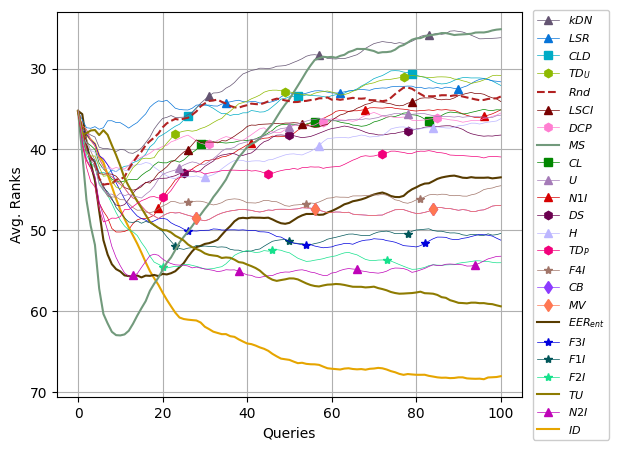

In [57]:
fig = plot_learning_curves(avg_ranks_df, classifier="SVC")

fig.savefig(f'ranking_curve_SVM.eps',format="eps", bbox_inches='tight')

### Compartamento de grupo de medidas por banda

In [29]:
def plot_group_bands(avg_ranks, ax, title=None):

    ax.set_title(title)
    ax.invert_yaxis()
    ax.grid(True)
    
    smoothed_ranks =  avg_ranks.groupby("method").transform( lambda x: x.rolling(window=5, min_periods=1).mean())
    
    df = smoothed_ranks.reset_index()
    df['group'] = df.method.apply(utils.get_hm_type)
    
    color_list = sns.color_palette(cc.glasbey_dark, n_colors=df['group'].nunique())
    i=0
    
    for group, data in df.groupby("group"):

        color = color_list[i]
        i+=1
        
        if group == 'Classic':
                
            continue
            

        min_ranks = data.groupby("query")["rank"].min()
        max_ranks = data.groupby("query")["rank"].max()
        
        ax.plot(max_ranks, color=color)
        ax.plot(min_ranks, color=color)
        ax.fill_between(np.arange(len(min_ranks)), min_ranks, max_ranks,
                        alpha=0.3,color=color, label=group,
                        hatch=utils.get_hm_hatch(group))

    for method, scores in df[df['group'] == 'Classic'].groupby("method", sort=False):
            ax.plot(scores["rank"].values, ':', linewidth=1,
                    label=utils.ABREV_DICT[method], color=COLOR_DICT[method])
       

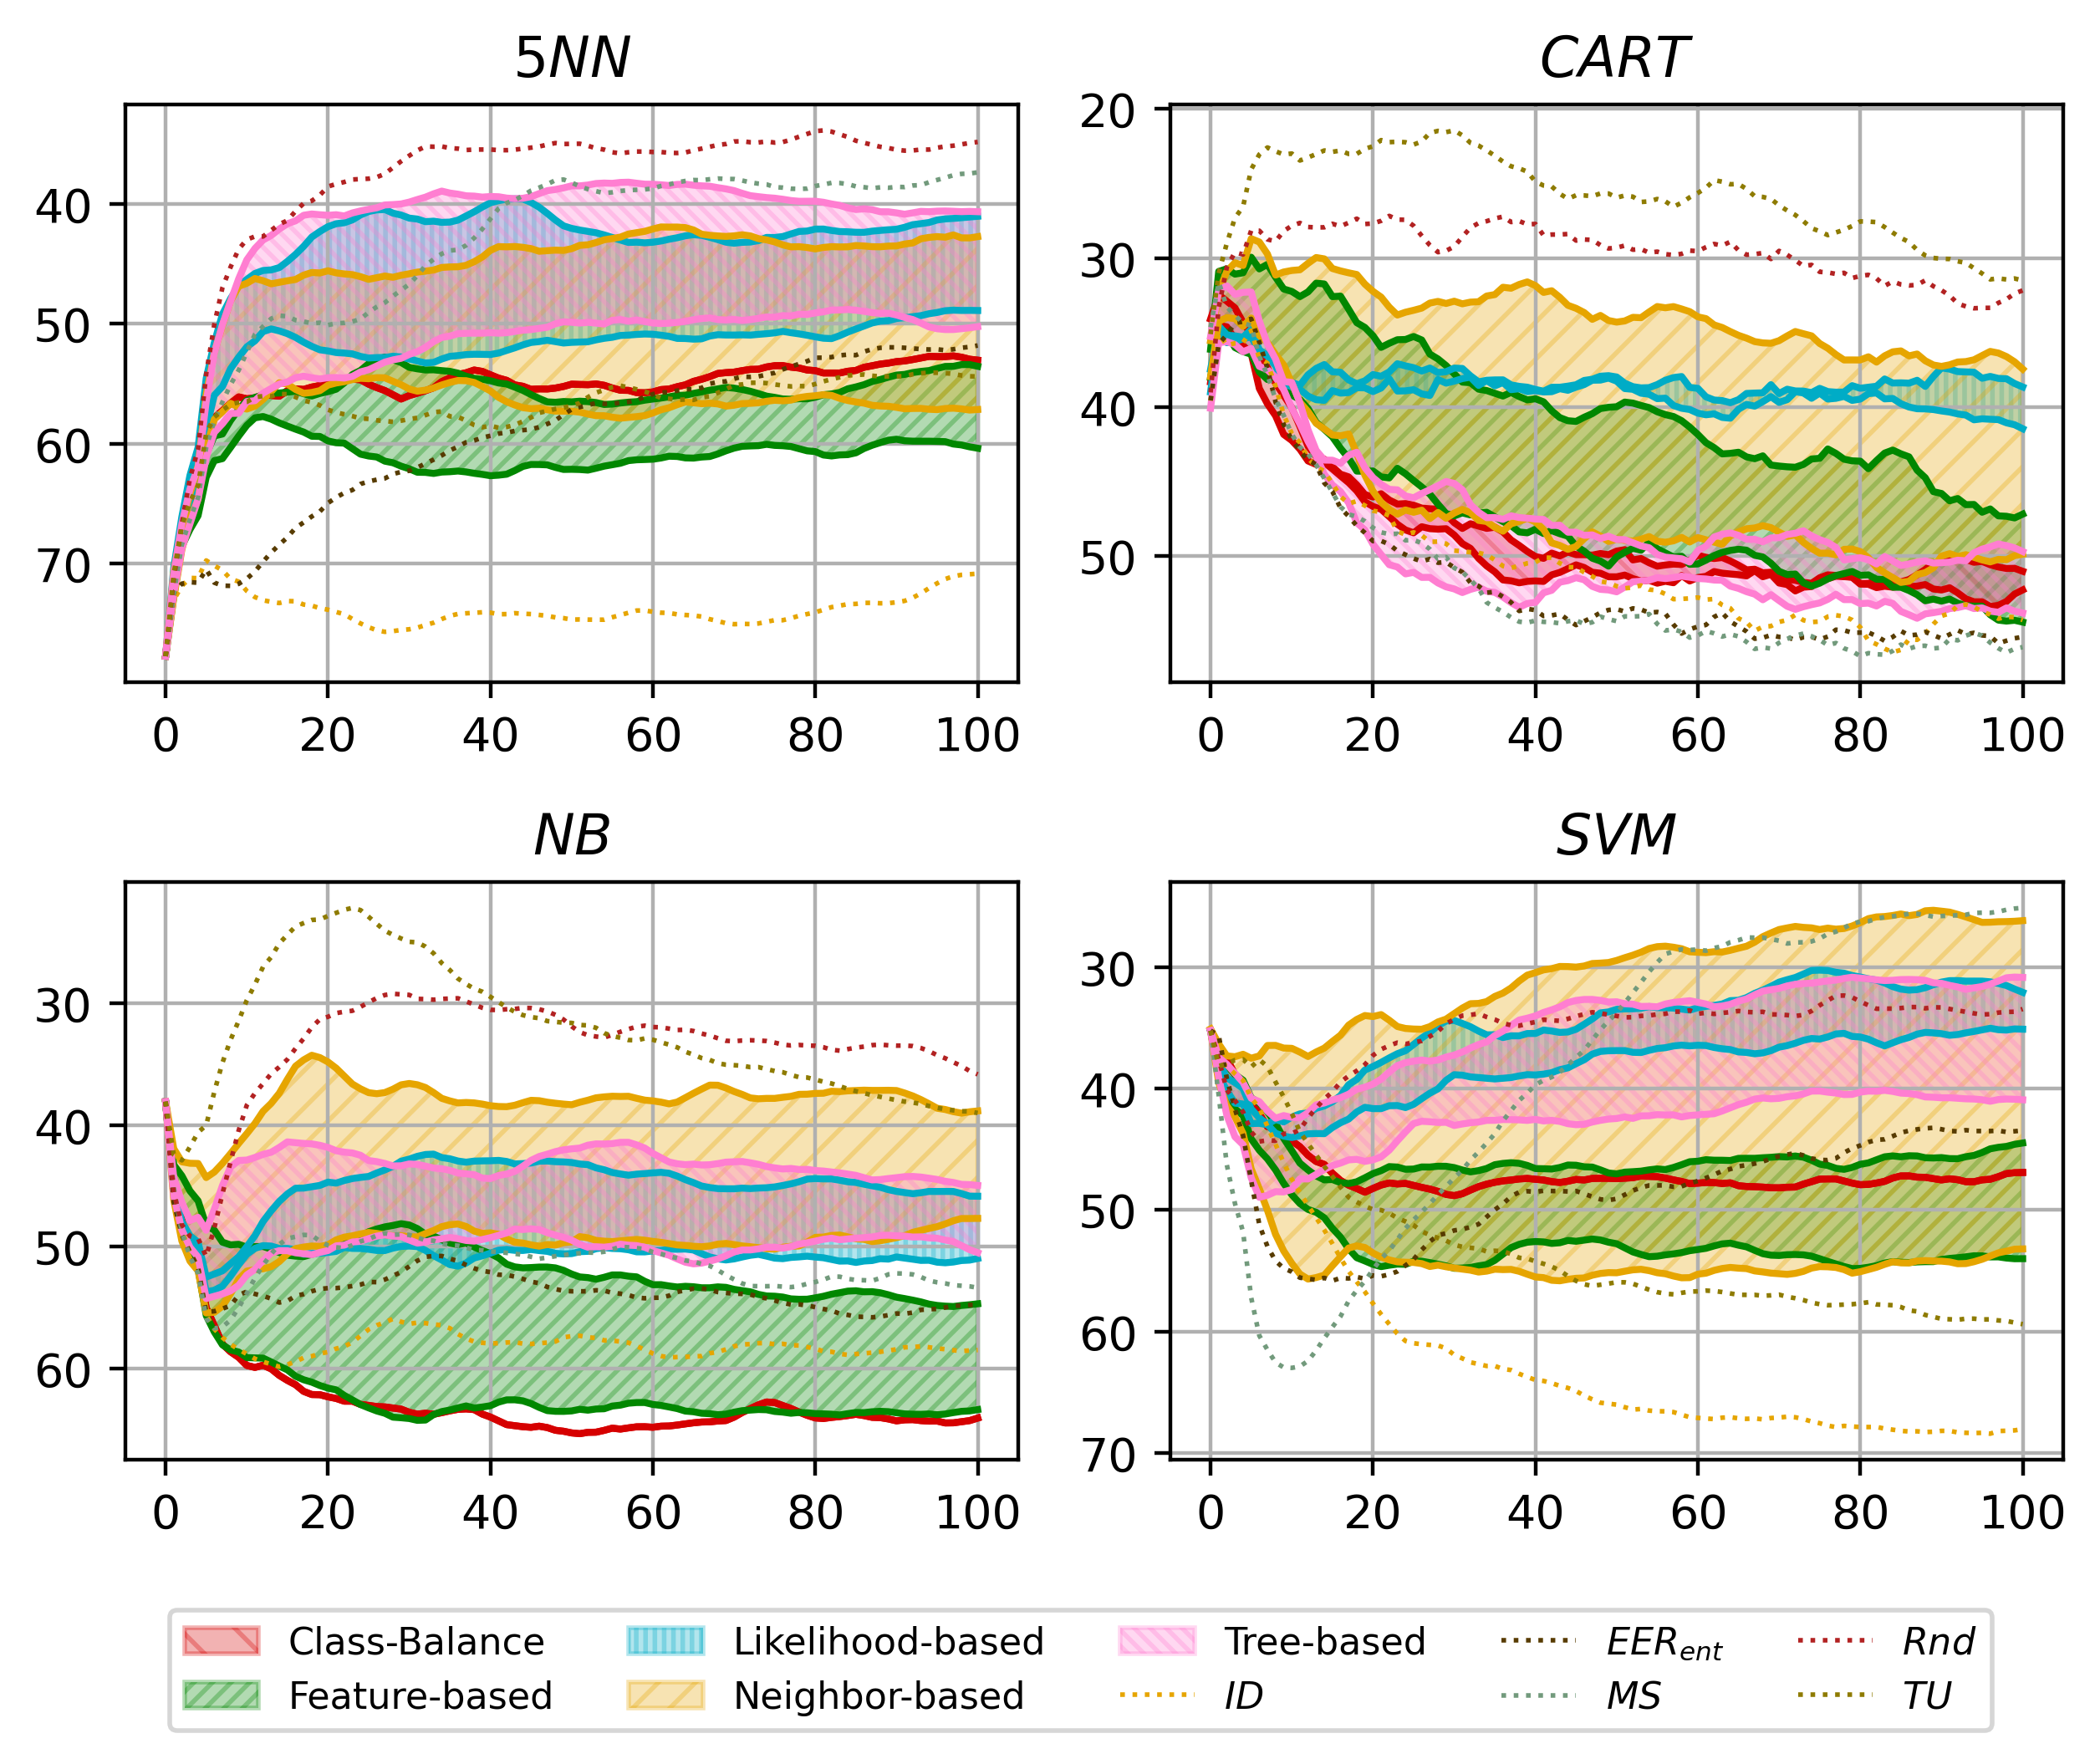

In [30]:
fig, axs = plt.subplots(2, 2)
for ax, clf in zip(axs.flatten(), sorted(utils.ABREV_MODEL.keys())):
    plot_group_bands(avg_ranks_df[clf], ax, title=utils.ABREV_MODEL[clf])
fig.tight_layout()
plt.legend(loc="lower center",bbox_to_anchor=(-0.1,-0.5),ncol=5, prop={'size': 8})

## Análise de Tempos de execução

In [31]:
duration_scores = results_df.groupby(["dataset", "classifier", "method"]).time.apply(lambda x: x.max() - x.min())

duration_df = duration_scores.reset_index().pivot(index=["classifier", "dataset"], columns=["method"], values="time")

def show_rank_diagram(clf):
    duration_df_clf = duration_df.loc[clf]
    
    avg_duration_rank = duration_df_clf.rank(axis=1).mean().sort_values()
    avg_duration_rank.index = avg_duration_rank.index.map(utils.ABREV_DICT.get)


    sig_matrix = sp.posthoc_nemenyi_friedman(duration_df_clf)
    sig_matrix.columns = sig_matrix.columns.map(utils.ABREV_DICT.get)
    sig_matrix.index = sig_matrix.index.map(utils.ABREV_DICT.get)
    
    res = sp.critical_difference_diagram(avg_duration_rank, sig_matrix) 
    
    plt.title('Runtime Ranks - ' + clf)


In [32]:
w.interact(show_rank_diagram, clf=w.ToggleButtons(options=sorted(utils.ABREV_MODEL.keys())))

interactive(children=(ToggleButtons(description='clf', options=('5NN', 'DecisionTree', 'GaussianNB', 'SVC'), v…

<function __main__.show_rank_diagram(clf)>

Analise proporcional ao tempo da amostragem aleatória:

In [33]:
avg_time_df = pd.concat([duration_df.loc[clf].apply(lambda x: x/x.random_sampling, axis=1).mean().rename(clf)
                         for clf in sorted(utils.ABREV_MODEL.keys())], axis=1).sort_values(by='5NN')
avg_time_df.style.background_gradient(axis=0, low=1).format(precision=0).format_index(utils.ABREV_DICT.get)

,5NN,DecisionTree,GaussianNB,SVC
method,,,,
$Rnd$,1,1,1,1
$MS$,1,1,1,2
$MV$,4,4,4,3
$CB$,4,4,4,3
$CL$,8,10,8,5
$CLD$,8,10,9,5
$DS$,10,5,8,5
$ID$,21,50,44,21
$TU$,22,51,44,21


## Comparação com resultados Davi

In [34]:
import pandas as pd

davi_results_file = 'neurocomputing2019-kappa-5x5-fold-75datasets-15strats-5classifs.csv'
col_names = ["dataset", "method", "classifier", "run", "fold", "query", "kappa"]

In [35]:
avaliable_learners = !cut -d',' -f3 $davi_results_file | sort | uniq
avaliable_learners

[' 5NN', ' C4.5', ' NB', ' RF', ' SVM']

In [36]:
avaliable_methods = !cut -d',' -f2 $davi_results_file| sort | uniq
avaliable_methods

[' ATUeuc',
 ' ATUmah',
 ' ATUman',
 ' ERE',
 ' HS',
 ' HTUeuc',
 ' HTUmah',
 ' HTUman',
 ' Mar',
 ' OER',
 ' Rnd',
 ' SG',
 ' TUeuc',
 ' TUmah',
 ' TUman']

In [167]:
selected_clfs = [" 5NN", " NB", " SVM"] 
selected_methods = [" ERE", " OER", " Rnd", " TUeuc", " Mar"]

In [168]:
resultados_davi = pd.read_csv(davi_results_file, names=col_names, chunksize=10000)
resultados_davi= pd.concat(chunk[(chunk.classifier.isin(selected_clfs)) & (chunk.method.isin(selected_methods) & (chunk["query"] < 100) &(chunk.run == 0 ))]
                     for chunk in resultados_davi)
resultados_davi.classifier = resultados_davi.classifier.str.strip()

In [169]:
def get_aulc(results_df):
    aulc_df =  (results_df.groupby(["dataset", "method", "classifier","run", "fold"])
                .kappa
                .apply(np.trapz)
                .groupby(["dataset", "method", "classifier"])
                .mean()
                .reset_index()
                .pivot(columns="method", index=["dataset", "classifier"], values="kappa")
               )
    return aulc_df

alc_davi = get_aulc(resultados_davi)

results_gabriel = results_df[results_df.method.map(utils.get_hm_type) == 'Classic'].copy()
results_gabriel.classifier = results_gabriel.classifier.map(
    {"SVC":"SVM", "GaussianNB":"NB", "5NN":"5NN", "DecisionTree":"CART"})
alc_gabriel = get_aulc(results_gabriel)

comparisson_df = alc_davi.join(alc_gabriel)

In [180]:
def compare_implementations(op1, op2):
    return (comparisson_df[op1] - comparisson_df[op2]).groupby('classifier').describe()
    
w.interact(compare_implementations, op1=w.ToggleButtons(options=comparisson_df.columns), op2=w.ToggleButtons(options=comparisson_df.columns))

interactive(children=(ToggleButtons(description='op1', options=(' ERE', ' Mar', ' OER', ' Rnd', ' TUeuc', 'den…

<function __main__.compare_implementations(op1, op2)>